# Genetic Algorithm for Smart Charging and Discharging of EVs

This is an attempt to model the smart charging and discharging of EVs using Genetic Algorithm. The dataset used is a 96-point load data curve. The input parameters are:

1.   Duration
2.   Arrival Time
3.   Arrival SOC



In [38]:
import csv
import matplotlib.pyplot as plt
import random

# Vehicle Distribubtion
Data was collected and sampled from NHTS Survey

48
85


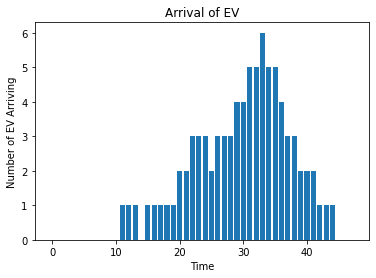

In [39]:
vehnum=[]
with open('./VPMARRIVAL1MIN.csv','r') as file:
    reader=csv.reader(file)
    i=0
    for row in reader:
        if i !=0 and i%2==0:
            vehnum.append(int(int(row[6])/1000))
        i+=1
print(len(vehnum))
# vehnum.sort()
vtot=0
for v in vehnum:
  vtot+=v
# print(vehnum[0],vehnum[95])
print(vtot)
plt.bar(range(len(vehnum)),vehnum)
plt.title("Arrival of EV")
plt.xlabel("Time")
plt.ylabel("Number of EV Arriving")
plt.show()

#Genetic Algorithm

1. Initialization
2. Fitness Calculation
3. Parent Selection
4. Crossover
5. Mutation

Steps 2 through 5 are looped for a fixed number of times.


##Initialization

In [40]:
#util
def interval_intersection(interval1, interval2):
    if interval1[1] < interval2[0] or interval2[1] < interval1[0]:
        return []
    else:
        start = max(interval1[0], interval2[0])
        end = min(interval1[1], interval2[1])
        return [start, end]

Naive

In [41]:
# #initialize population
# import random
# best=-100000
# #parent_econload_gene=([random.randint(300,434) for x in range(5)])
# cars=[]
# soc=[random.uniform(0.8,1)for i in range(154)]
# print(len(soc))
# for t in range(0,48):
#   for i in range(0,vehnum[t]):
#     cars.append({"t":t,"d": random.randint(8,12),"Pev":[0 for x in range(96)]})
# i=0
# print(len(cars))
# for car in cars:
#   for t in range(car["t"],car["t"]+int(4*car["d"])):
#     interval=interval_intersection([-7.2,7.4],[-soc[i][t]*156,156-soc[i][t]*156])

#     if interval !=[]:
#       car["Pev"][t]=random.uniform(interval[0],interval[1])
#       #print(car["Pev"][t])
#   i+=1
# parent_cars_gene=([[random.randint(-1,1) for x in range(65)] for i in range(5)])
# new_populations = []
# print(cars)

In [42]:
dur=[random.randint(8,12) for x in range(vtot)]
len(dur)

85

Random shuffling of (-1,1)

In [43]:
#initialize population

#parent_econload_gene=([random.randint(300,434) for x in range(5)])
cars=[[random.uniform(-(7.2/7.4),1) for i in range(vtot*96)]for x in range(100)]
dur=[random.randint(8,12)*4 for x in range(vtot)]
start=[i for i in range(48) for v in range(vehnum[i])]

end=[start[i]+dur[i] for i in range(vtot)]
#print(len(start))
soc=[0 for x in range(vtot*96) ]

for j in range(vtot):
    soc[96*j+start[j]]=round(random.uniform(0.5,1),2)
ogsoc=soc

ebattery=[round(soc[96*x+start[x]]*39,2) for x in range(vtot)]
ogebattery=ebattery

t=0
arrival=vehnum+[0 for i in range(48)]
freq={}
for i in end:
  if i in freq:
    freq[i]+=1
  else:
    freq[i]=1
depart=[0 for i in range(96)]
for i in range(96):
  if i in freq:
    depart[i]=freq[i]

vehpresent=[0 for i in range(96)]
vehpresent[0]=arrival[0]-depart[0]

for i in range(1,96):
  vehpresent[i]=vehpresent[i-1]+arrival[i]-depart[i]


In [44]:
ebattery

[24.57,
 30.81,
 34.71,
 32.37,
 37.44,
 29.64,
 24.96,
 29.64,
 30.03,
 37.05,
 27.3,
 25.35,
 21.84,
 30.03,
 25.74,
 26.52,
 38.61,
 19.89,
 27.69,
 32.37,
 25.35,
 30.42,
 38.61,
 32.76,
 23.01,
 37.83,
 26.52,
 32.37,
 38.22,
 30.81,
 37.83,
 31.59,
 30.81,
 23.79,
 35.1,
 19.89,
 36.27,
 35.88,
 34.32,
 29.25,
 31.2,
 38.61,
 24.18,
 26.52,
 30.03,
 36.66,
 22.23,
 25.35,
 24.57,
 36.27,
 27.69,
 23.01,
 35.88,
 19.89,
 28.08,
 26.91,
 35.1,
 32.37,
 37.44,
 22.23,
 38.61,
 31.98,
 38.22,
 36.66,
 38.61,
 32.76,
 32.76,
 23.4,
 37.44,
 32.37,
 34.32,
 37.05,
 34.71,
 26.52,
 23.4,
 35.1,
 27.3,
 26.91,
 28.47,
 32.37,
 31.59,
 31.2,
 20.28,
 29.64,
 24.57]

Text(0, 0.5, 'Load Demand in KW')

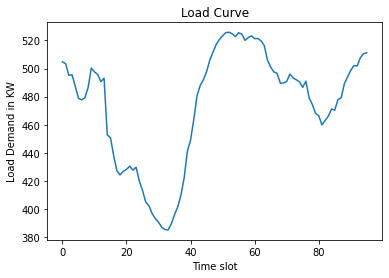

In [45]:
P_load=[]
with open('./loadcurve.csv','r') as file:
    reader=csv.reader(file)
    i=0
    for row in reader:
        if i !=0:
            P_load.append(float(row[4]))
        i+=1

plt.plot(P_load)
plt.title("Load Curve")
plt.xlabel("Time slot")
plt.ylabel("Load Demand in KW")

##Fitness Score Calculation

In [46]:

import numpy as np
pev=7.4
def fitness():
  global cars, P_load,fit_value,soc_value,best_fitness
  best_fitness=-100000

  fit_value=[]
  soc_value=[]
  for i in range(0,100):
    obj_fun=0
    P_econload=470
    reward=0
    soc=ogsoc
    ebattery=ogebattery
    for t in range(0,96):
        sum_pev=0
        for j in range(0,vtot):
            if start[j]<t and t<=end[j]:
              val=ebattery[j]+cars[i][t*vtot+j]*pev/4
              if round(val,2)>=0.4*39 and round(val,2)<39:
                ebattery[j]=round(val,2)
                sum_pev+=cars[i][t*vtot+j]*pev
                soc[96*j+t]=round((ebattery[j])/39,2)
            if t>end[j]:
              soc[96*j+t]=soc[96*j+end[j]]
            if t==end[j]:
              # print(soc[96*j+end[j]])
              if 0.9<soc[96*j+end[j]]<=1:
                # print(2) 
                reward+=1
              if 0.7<soc[96*j+end[j]]<=0.9:
                reward+=0.8
              if 0.6<soc[96*j+end[j]]<=0.7:
                reward+=0.1
        obj_fun=round((obj_fun+P_load[t]-P_econload+sum_pev),2)
      
    fitness_score=100000/abs(obj_fun+0.0005)
    # print("fitness:",fitness_score)

    fitness_score+=(fitness_score*reward)/100 
    #1000 worked well
    fit_value.append(fitness_score)
    soc_value.append(soc)

    


In [47]:
#selecting parents....

def selectparent():
    global fit_value,parents,best_soc,best_fitness,max_fitness_idx
    parents =[[0 for i in range(vtot*96)]for j in range(100)]
    best_soc=[[0 for i in range(vtot*96)]for j in range(100)]
    for parent_num in range(100):

        max_fitness_idx_arr = np.where(fit_value == np.max(fit_value))
        max_fitness_idx = max_fitness_idx_arr[0][0]
        
        parents[parent_num] = cars[max_fitness_idx]
        best_fitness=max(fit_value[max_fitness_idx],best_fitness)
        best_soc[parent_num] = soc_value[max_fitness_idx]
        fit_value[max_fitness_idx] = -99999999999
# selectparent()
#print(len(parents))

## Crossover

In [48]:
# import numpy as np
# def PMX_crossover(parent1, parent2, seed):
#     '''
#     parent1 and parent2 are 1D np.array
#     '''
#     rng = np.random.default_rng(seed=seed)

#     cutoff_1, cutoff_2 = np.sort(rng.choice(np.arange(len(parent1)+1), size=2, replace=False))

#     def PMX_one_offspring(p1, p2):
#         offspring = np.zeros(len(p1), dtype=p1.dtype)

#         # Copy the mapping section (middle) from parent1
#         offspring[cutoff_1:cutoff_2] = p1[cutoff_1:cutoff_2]

#         # copy the rest from parent2 (provided it's not already there
#         for i in np.concatenate([np.arange(0,cutoff_1), np.arange(cutoff_2,len(p1))]):
#             candidate = p2[i]
#             while candidate in p1[cutoff_1:cutoff_2]: # allows for several successive mappings
#                 print(f"Candidate {candidate} not valid in position {i}") # DEBUGONLY
#                 candidate = p2[np.where(p1 == candidate)[0][0]]
#             offspring[i] = candidate
#         return offspring

#     offspring1 = PMX_one_offspring(parent1, parent2)
#     offspring2 = PMX_one_offspring(parent2, parent1)
#     parents=parents+offspring1
#     parents=parents+offspring2

#     return offspring1, offspring2


# newcars=parents

In [49]:
from operator import add,sub
def crossover():
     global parents,offspring 
     offspring = [[0 for i in range(vtot*96)]for j in range(100)]
     # The point at which crossover takes place between two parents. Usually, it is at the center.
     crossover_point = 154*96//2
 
     for k in range(100):
         # Index of the first parent to mate.
         pshape=100
         parent1_idx = k%pshape
         # Index of the second parent to mate.
         parent2_idx = (k+1)%pshape
         for i in range(96):
         # The new offspring will have its first half of its genes taken from the first parent.
          offspring[k][i*vtot:(i*vtot+vtot)//2] = parents[parent1_idx][i*vtot:(i*vtot+vtot)//2]
         # The new offspring will have its second half of its genes taken from the second parent.
          offspring[k][(i*vtot+vtot)//2:(i*vtot+vtot)] = parents[parent2_idx][(i*vtot+vtot)//2:(i*vtot+vtot)]
#crossover()
#print(parents)
    

In [50]:
def mutation():
    global offspring
    for idx in range(len(offspring)):
        # The random value to be added to the gene.
          random_value = random.uniform(-(7.2/7.4),1.0)
          offspring[idx][154] = (offspring[idx][154] + random_value)/2
    return offspring
#mutation()

In [51]:
global parents,best
new_pop=[[0 for i in range(vtot*96)]for j in range(100)]
best=[]
count=0
for i in range(0,100):
    if count>=20:
      break
    if len(best)>=2 and abs(best[i-2]-best[i-1])<0.5:
      count+=1
    elif len(best)>=2 and  abs(best[i-2]-best[i-1])>=0.5:
      count=0
      
    fitness()
    selectparent() 
    crossover()
    offspring_mutation=mutation()
    new_pop = offspring_mutation
    cars=new_pop
    # print(len(cars))
    print("best",i,":",best_fitness)
    best.append(best_fitness)
    # print(fit_value[0])

best 0 : 5327.621244576261
best 1 : 2482.6894649942515
best 2 : 3788.7877142243706
best 3 : 6782.978114036135
best 4 : 25075.0364462739
best 5 : 2749.524312369871
best 6 : 4838.011574036966
best 7 : 3892.000379707354
best 8 : 9504.067338798328
best 9 : 1769.7857525787847
best 10 : 53211.009174311934
best 11 : 11108.010047446274
best 12 : 3746.7617820089063
best 13 : 14051.873739505649
best 14 : 8507.390972555891
best 15 : 9430.020889286781
best 16 : 1287.6751713052304
best 17 : 12867.791290702235
best 18 : 300000000.0
best 19 : 2476.545991235066
best 20 : 39563.475618179305
best 21 : 8333.572803816201
best 22 : 4928.227092704432
best 23 : 1391.6966560090991
best 24 : 7302.941394018588
best 25 : 1952.2454693840682
best 26 : 9805.69211732049
best 27 : 6690.797904629151
best 28 : 8193.75156768206
best 29 : 3899.70651693223
best 30 : 16414.544254359425
best 31 : 2610.7031227733496
best 32 : 2027.8410317476894
best 33 : 2936.2572012637056
best 34 : 15910.873999686173
best 35 : 5885.88339990

In [52]:
len(best)

100

Text(0, 0.5, '% SOC')

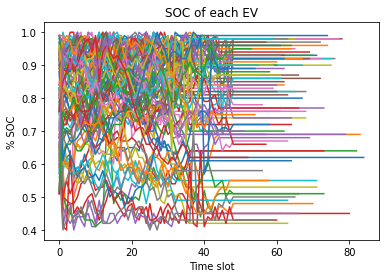

In [53]:
for j in range(vtot):
    plt.plot(best_soc[len(best_soc)-1][j*96+start[j]:j*96+96])
plt.show
plt.title("SOC of each EV")
plt.xlabel("Time slot")
plt.ylabel("% SOC")

In [54]:
max_fitness_idx
cars[max_fitness_idx]

[0.5329199996021182,
 -0.41615262392105945,
 0.8245269490549513,
 -0.8623242032051076,
 0.4369497221355244,
 0.5241396159624166,
 0.23693391320857604,
 -0.5086872805955288,
 0.606070269470324,
 -0.3475192241674526,
 -0.41694511681235946,
 -0.4483352355447203,
 -0.29534039628690933,
 -0.5678382589854976,
 0.15950967134153393,
 -0.4596597401424327,
 0.9396748924573922,
 -0.7314172895104205,
 0.1406214494266419,
 0.6488313150845876,
 0.8684726646313542,
 0.16033882917061082,
 0.705417547083209,
 0.8986091243125501,
 0.3755965482357525,
 -0.562991722357755,
 -0.6802614680300136,
 -0.4628112182194891,
 0.818451365323391,
 -0.281633312904482,
 0.4296771855044882,
 -0.8560604480334087,
 0.1635307883183298,
 -0.4183774157146225,
 0.10255251756017325,
 0.3898530835871895,
 -0.23908634301690979,
 0.3272426735634494,
 -0.3561516383306903,
 0.8197753922146455,
 -0.5382512365738625,
 0.7720677680703646,
 -0.19305281636893246,
 0.7729174158016577,
 0.7847215225795489,
 -0.785401778319391,
 -0.447092

In [55]:
sum_pev1=[]
for t in range(0,96):
        temp_val = 0
        for j in range(0,vtot):
            temp_val+=cars[max_fitness_idx][t*vtot+j]
        sum_pev1.append(temp_val)
        temp_val = 0

sum_pev1[20]

9.836389913694548

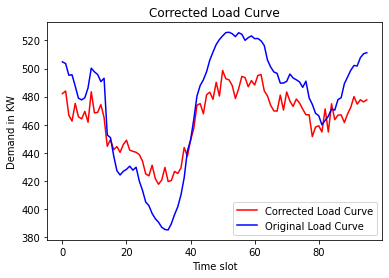

In [59]:
P_load_corrected=[]
for i in range(0,96):
    P_load_corrected.append( P_load[i] +225-P_load[i]/2 +( sum_pev1[i]))

plt.plot(P_load_corrected,'r')
plt.plot(P_load,'b')
plt.title("Corrected Load Curve")
plt.xlabel("Time slot")
plt.ylabel("Demand in KW")
plt.legend(["Corrected Load Curve", "Original Load Curve"], loc ="lower right")

In [ ]:
#P_load_corrected.append( P_load[i] +225-P_load[i]/2 +( sum_pev1[i]))